In [4]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time


In [5]:
import PIL
import glob

In [6]:
import random

# importing the images

In [7]:
path = "/kaggle/input/animefacedataset/images/*.jpg"
files = glob.glob(path)
Images = []
i = 0
for file in files:
    i += 1
    if(i>20000):
        break
    image = PIL.Image.open(file)
    image = image.resize((64,64))
    rgb_pixels = np.array(image)
    Images.append(rgb_pixels)

In [8]:
print(len(Images))
print("new image shape is ", Images[0].shape)

20000
new image shape is  (64, 64, 3)


## ploting a random img to see if the import is correct


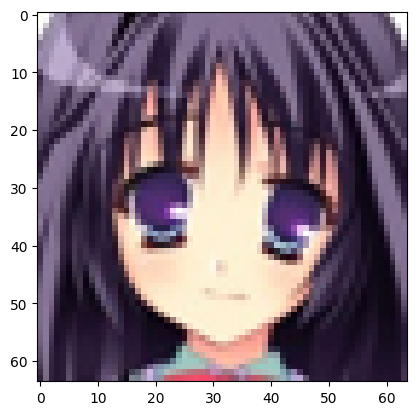

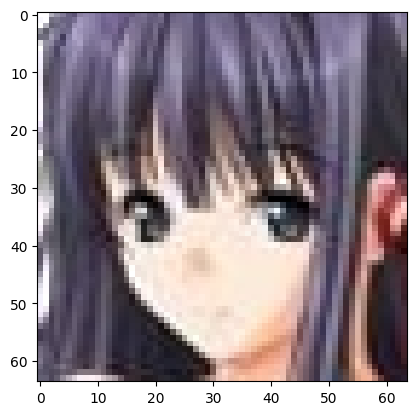

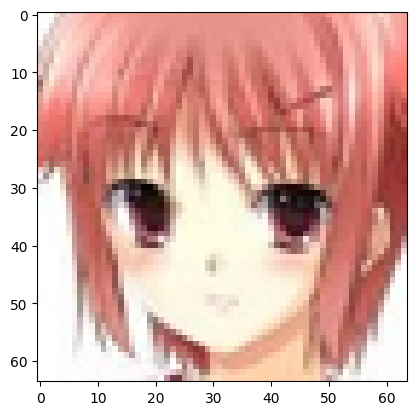

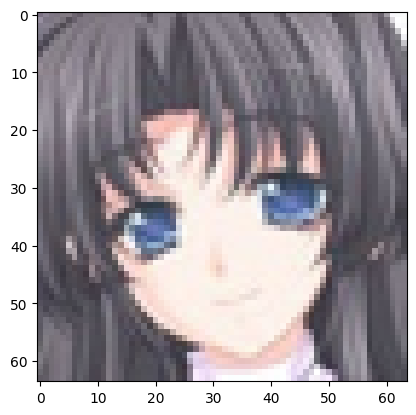

In [10]:
start,end = 0,len(Images)-1
for i in range(4):  
    n = random.randint(0, len(Images) - 1)  
    fig = plt.figure(i)  
    plt.imshow(Images[n])  
    plt.show()  

## spliting into test and train data

In [11]:
split = len(Images)//10

test = Images[0:split]
train = Images[split:len(Images)]

test = np.array(test)
train = np.array(train)

In [12]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 64, 64, 3)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train)
test_images = preprocess_images(test)

In [13]:
print("shape of train data is now ", train.shape)

shape of train data is now  (18000, 64, 64, 3)


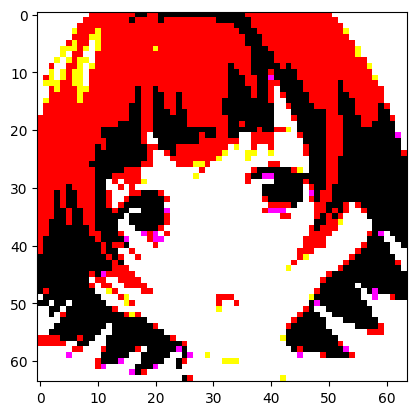

In [14]:
n = random.randint(0, len(train_images) - 1)
fig = plt.figure(i)
plt.imshow(train_images[n]) 
plt.show()


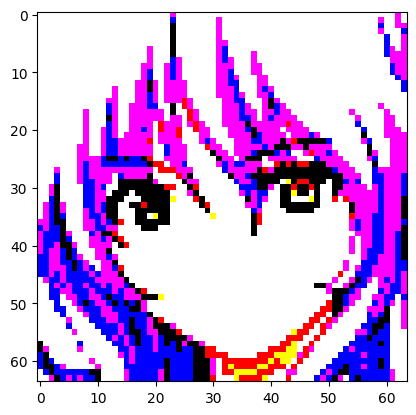

In [15]:

n = random.randint(0, len(test_images) - 1)
fig = plt.figure(i)
plt.imshow(test_images[n])
plt.show() 

In [16]:
train_size = train_images.shape[0]
batch_size = 32
test_size = test_images.shape[0]

# Making the model


In [17]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape

In [18]:
from tensorflow.keras import backend as K

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()

In [20]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [21]:
#Sampling Layer

class Sampling(layers.Layer):
    #We create a new layer by subclassing the keras base Layer
    def call(self, inputs):
        #
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [22]:
# Encoder

image_size = 64
embed_dim = 8
n_channels = 3
encoder_input = layers.Input(
    shape=(image_size, image_size, n_channels), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

#Instead of connecting the Flatten layer directly to the 2D latent space,
#we will connect it to layers z_mean and z_log_var.
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)

#The Sampling layer samples a point z in the latent space from the
#normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

#The Keras Model that defines the encoder—a model that takes an input
#image and outputs z_mean, z_log_var and a sampled point z from the
#normal distribution defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     73,792 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │     32,776 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │     32,776 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,592 (908.56 KB)

 Trainable params: 232,592 (908.56 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Decoder
decoder_input = layers.Input(shape=(embed_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(
    128, (3, 3), activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    n_channels,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        36,896 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,131 (1.13 MB)

 Trainable params: 296,131 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
            #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
            #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
            #These gradients are then used to update the variables with the optimizer.

            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.mean_squared_error(
                    data, reconstruction
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [30]:
vae = VAE(encoder, decoder)

In [31]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [32]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="/kaggle/working/new_output.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [38]:
vae.fit(
    train_images,
    epochs=21,
    batch_size=50,
    shuffle=True,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/21
324/324 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - kl_loss: 7.0534 - reconstruction_loss: 64.8914 - total_loss: 71.9449 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/21
324/324 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - kl_loss: 7.1808 - reconstruction_loss: 64.6261 - total_loss: 71.8069 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/21
324/324 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - kl_loss: 7.1919 - reconstruction_loss: 64.1876 - total_loss: 71.3796 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/21
324/324 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - kl_loss: 7.2062 - reconstruction_loss: 64.3520 - total_loss: 71.5582 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/21
324/324 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - kl_loss: 7.2345 - reconstruction_loss: 63.7839 - total_loss: 71.0184 - v

# printing some ramdom samples


In [39]:
import matplotlib.pyplot as plt

def plot_images_in_grid(images, n):
    """Plots a grid of images.

   Args:
       images: A numpy ndarray containing images to plot, with shape (height, width, channels).
       n: The size of the grid (n*n).
   """

    fig, axes = plt.subplots(n, n, figsize=(30,30))  # Create a figure and a grid of subplots

    for i, ax in enumerate(axes.flat):  # Iterate through each subplot
        ax.imshow(images[i])  # Plot the image
        ax.axis('off')  # Turn off axis labels and ticks

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()  # Display the plot




In [82]:
def plot_function(n,a,b):
    # Specify the size of the grid
    # Example: Plot a 5*5 grid
    random_sample = []
    for i in range(n*n):
        rand_ = (b) * np.random.standard_normal(size = (8)) + a
        random_sample.append(rand_)

    random_sample = np.array(random_sample)
    print("(a,b):" , a , b)
    img_new = decoder.predict(random_sample)
    plot_images_in_grid(img_new, n)

(a,b): -1.5 0.9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


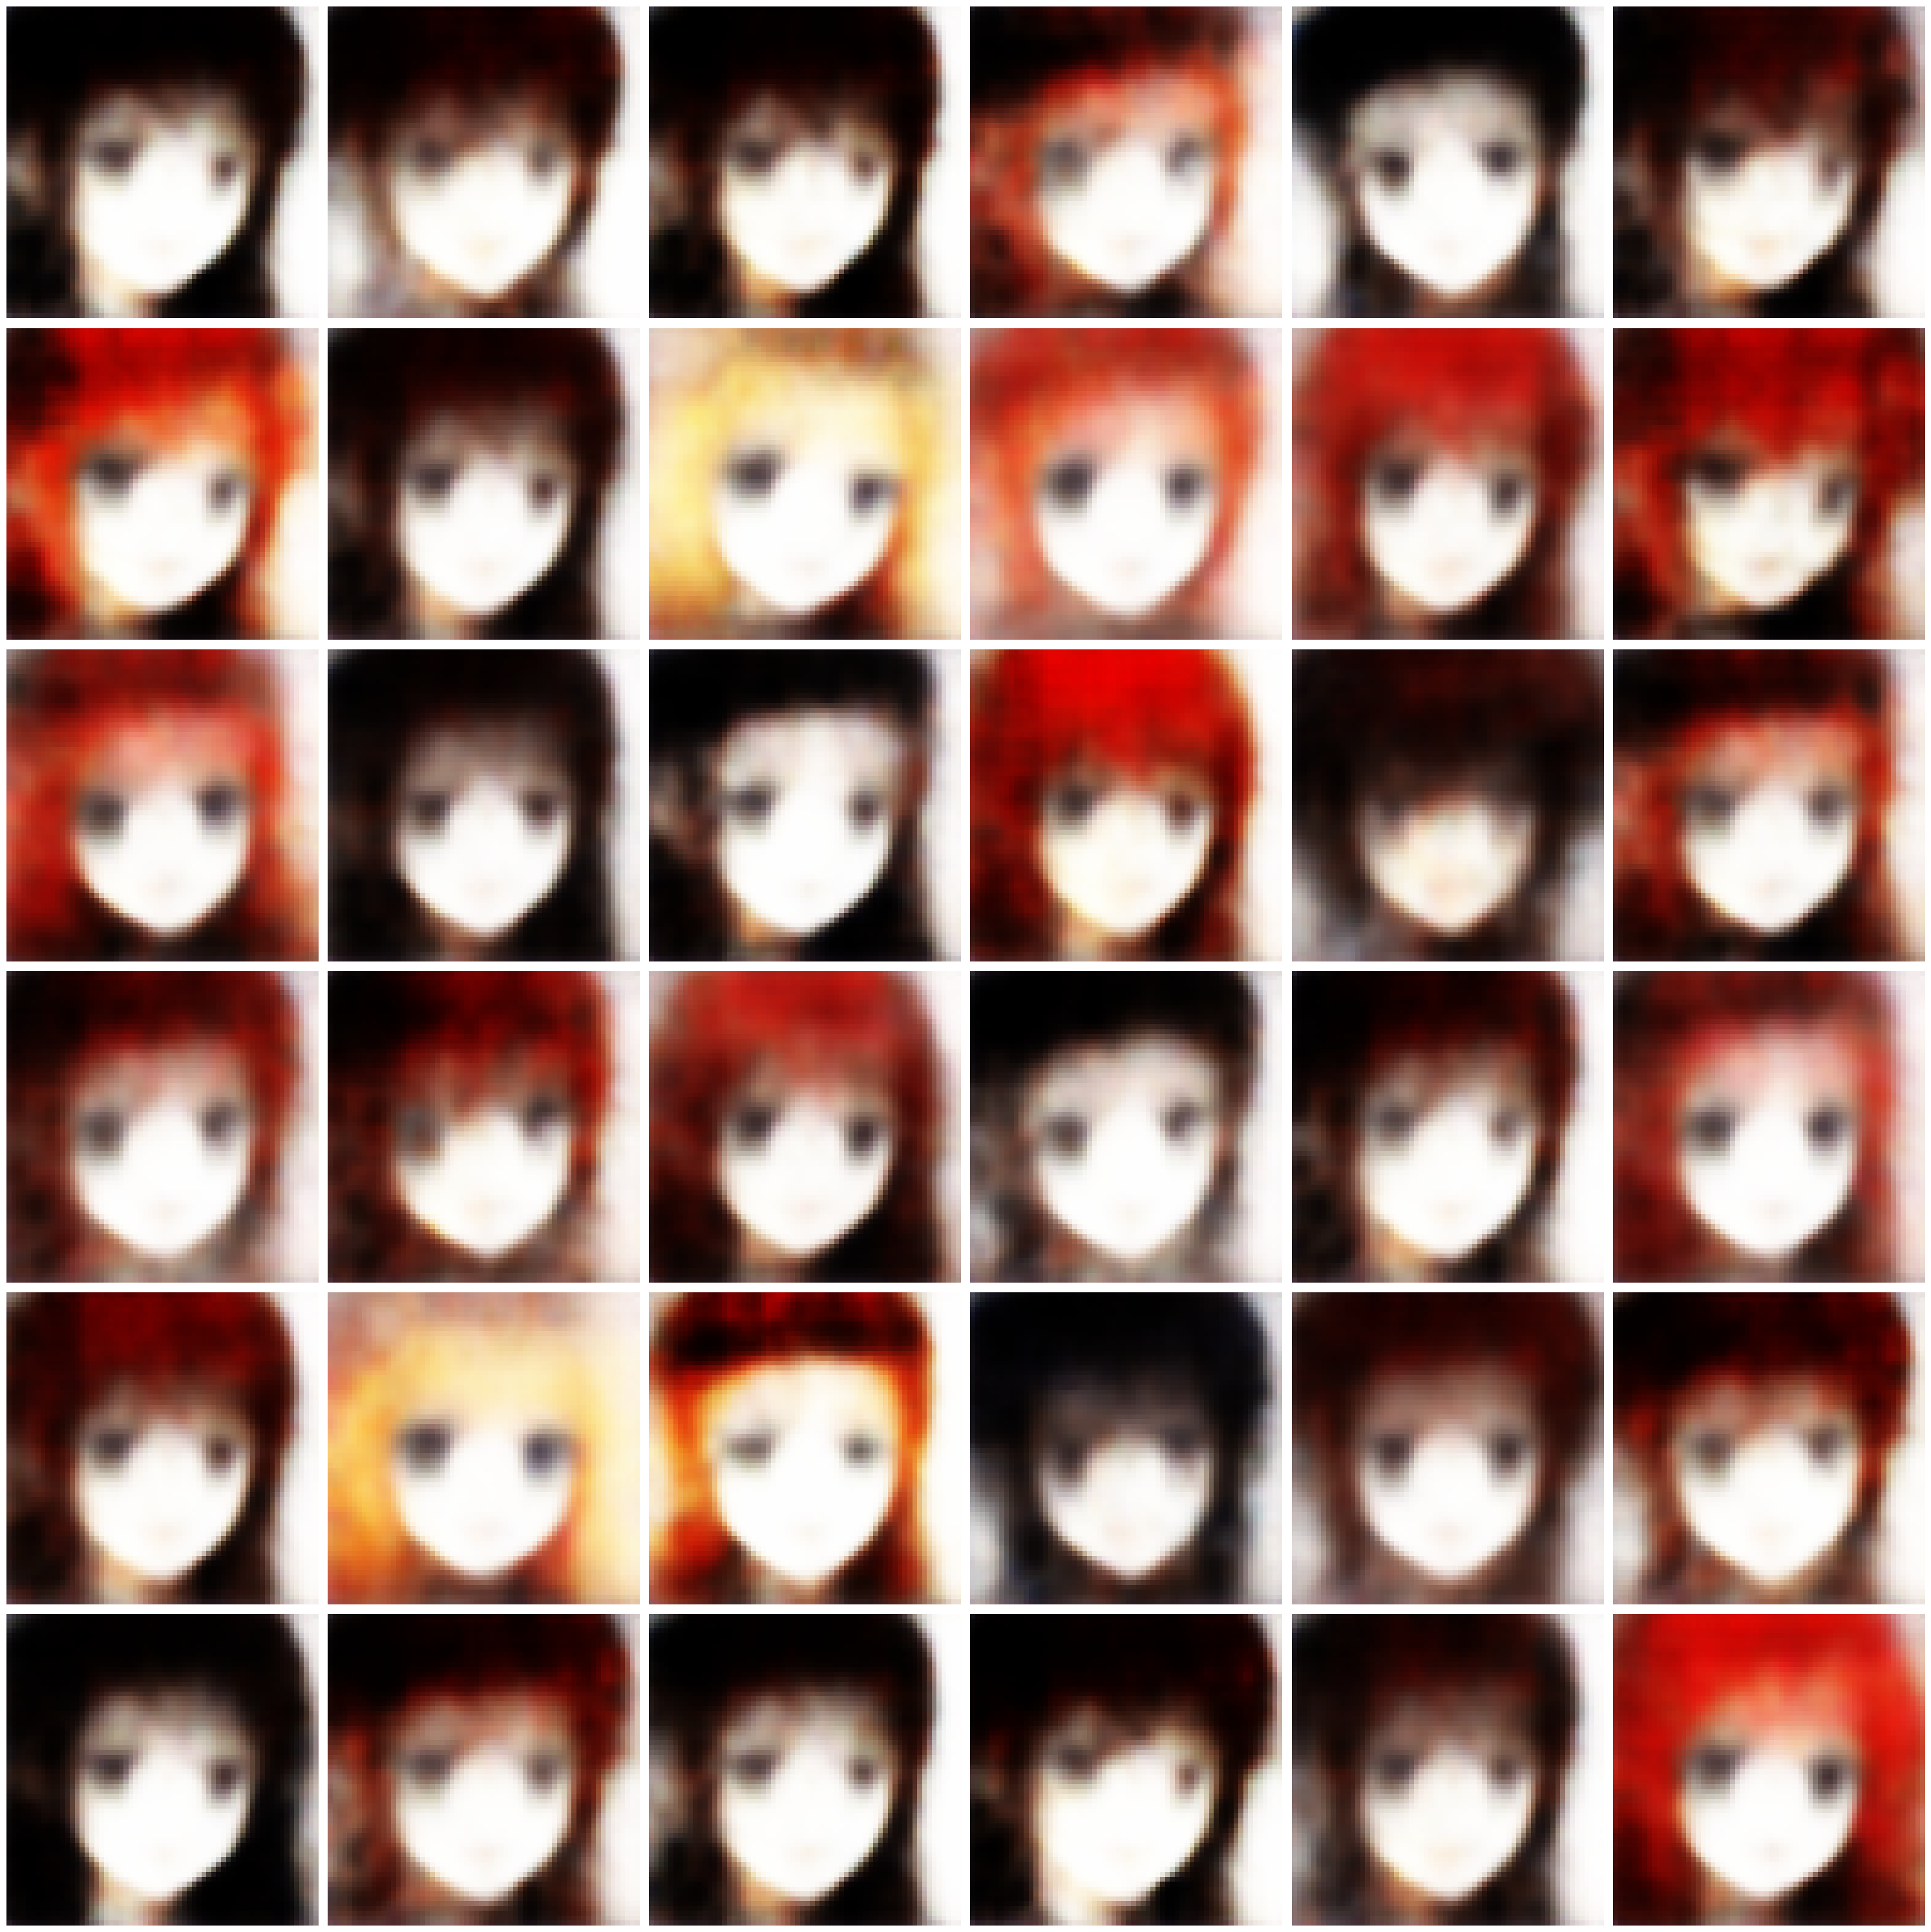

(a,b): -0.5 0.9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


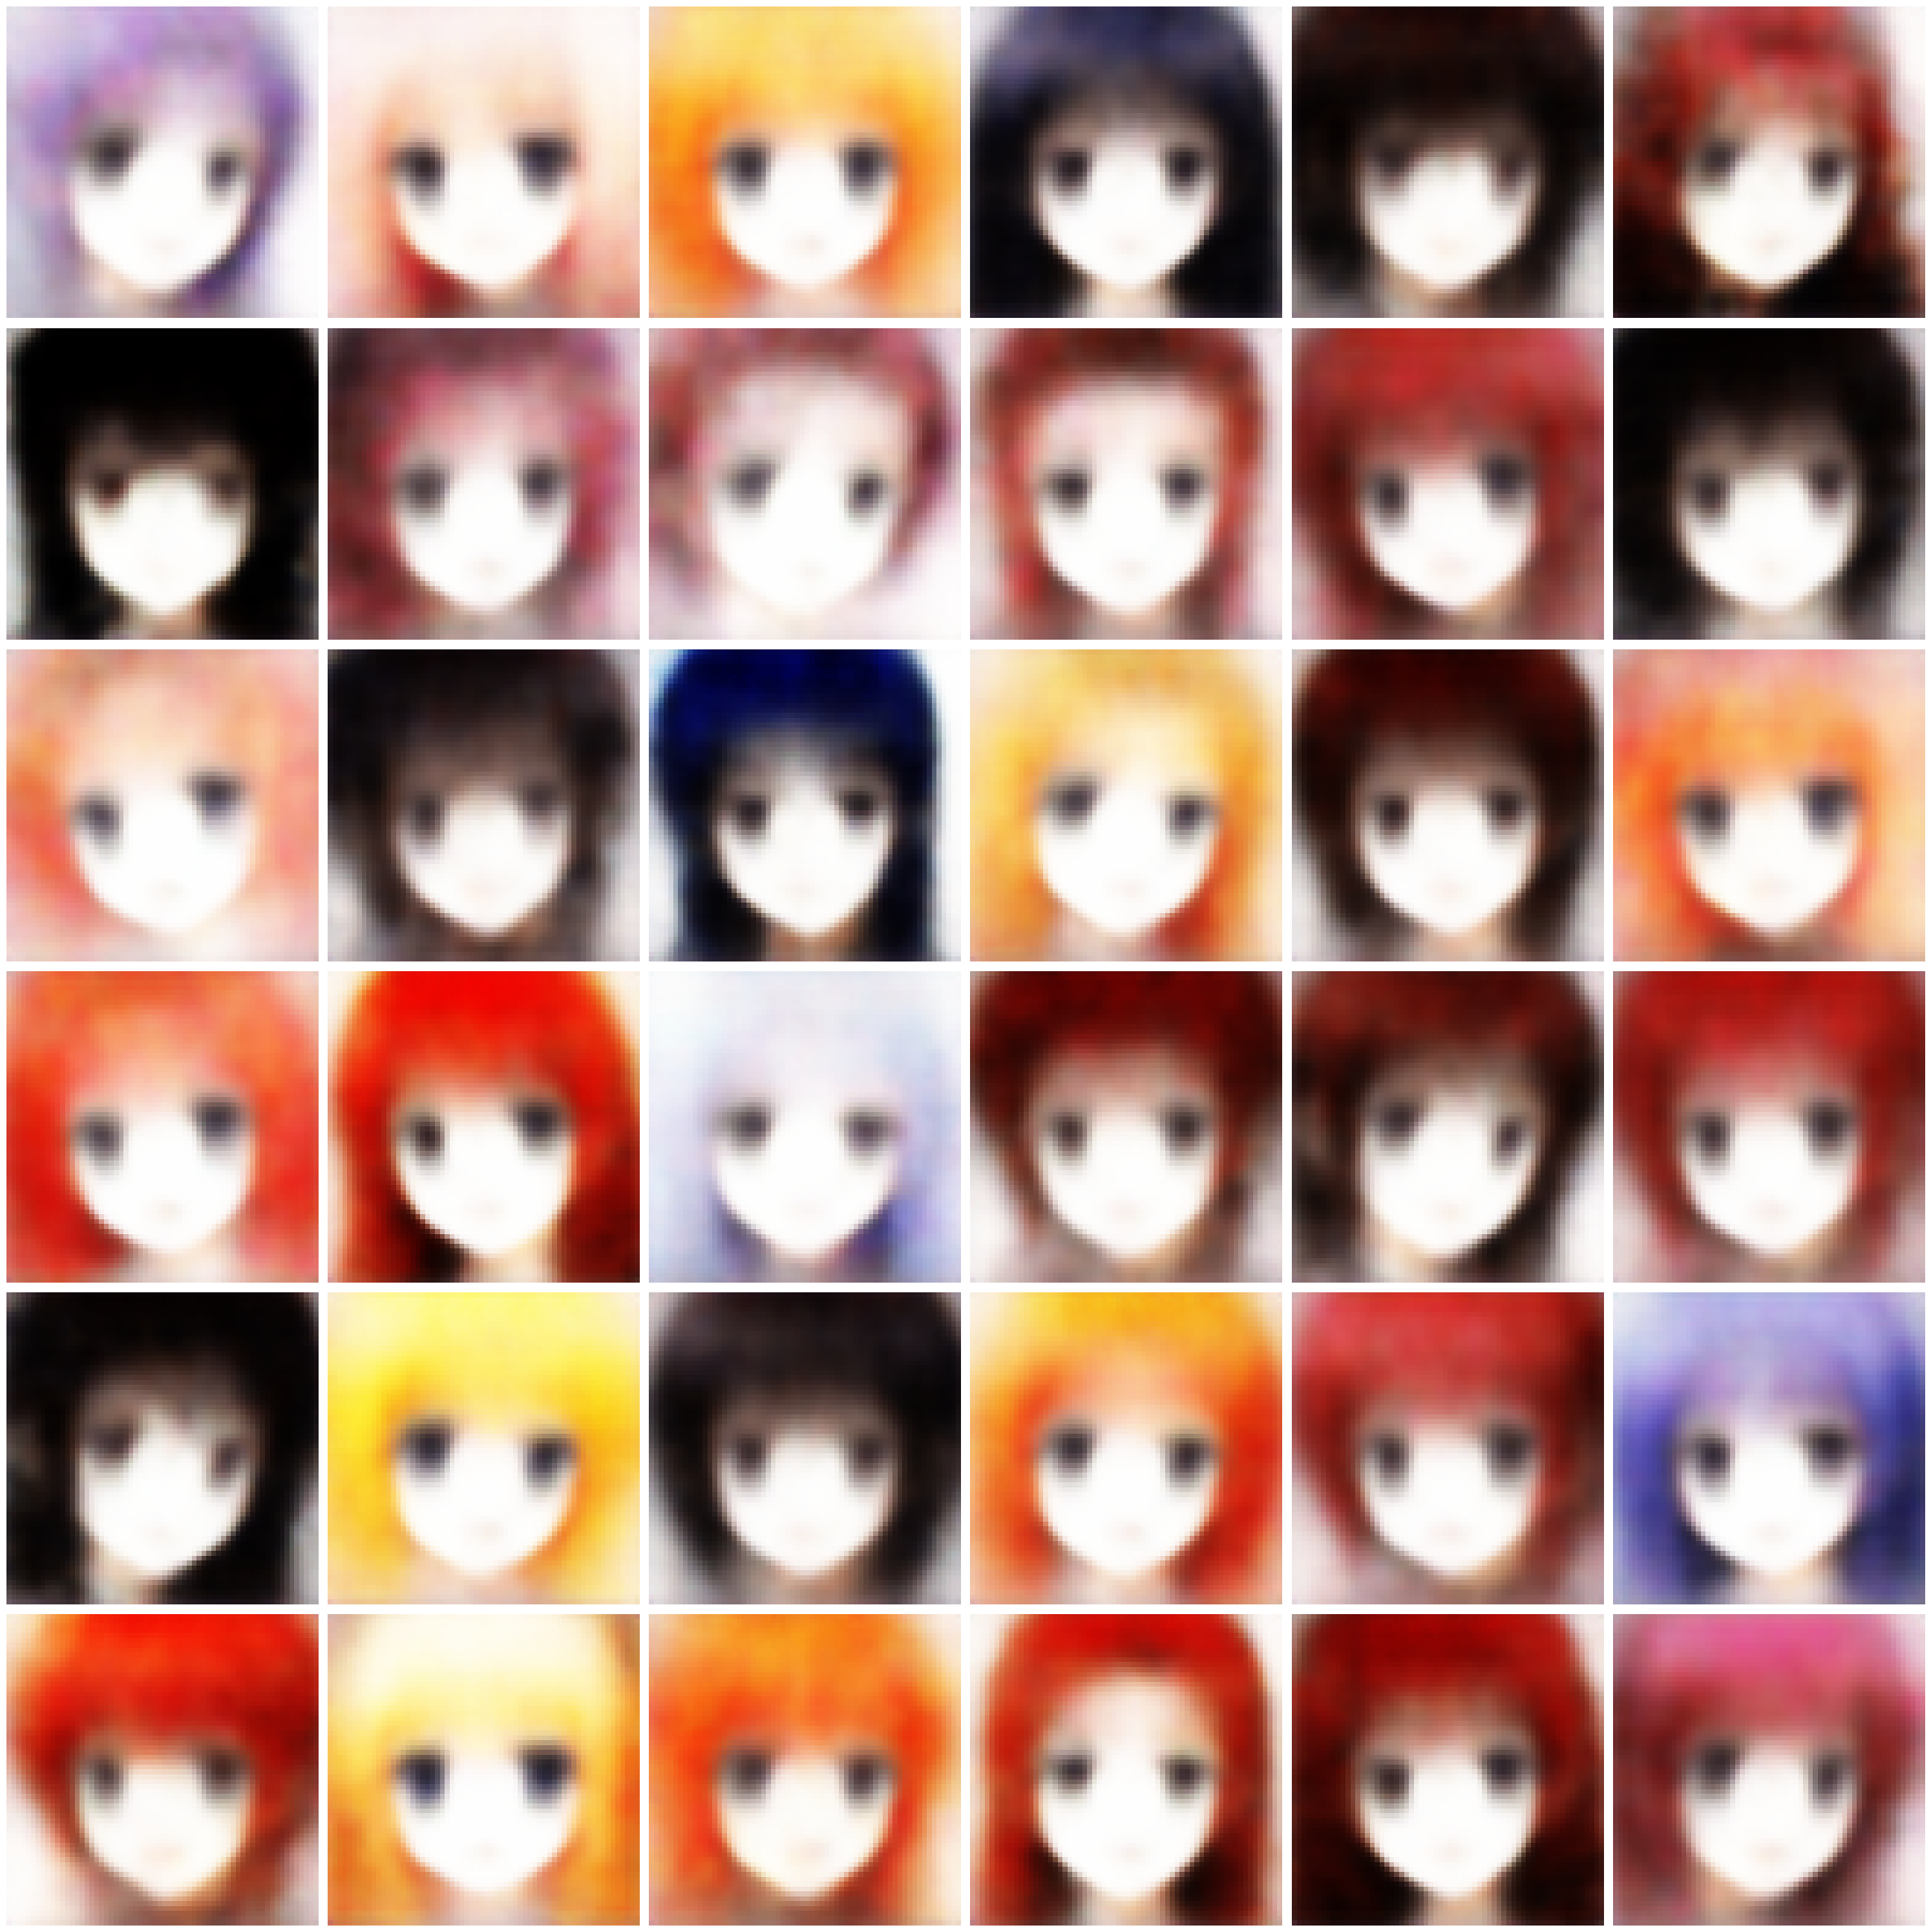

(a,b): 0.5 0.9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


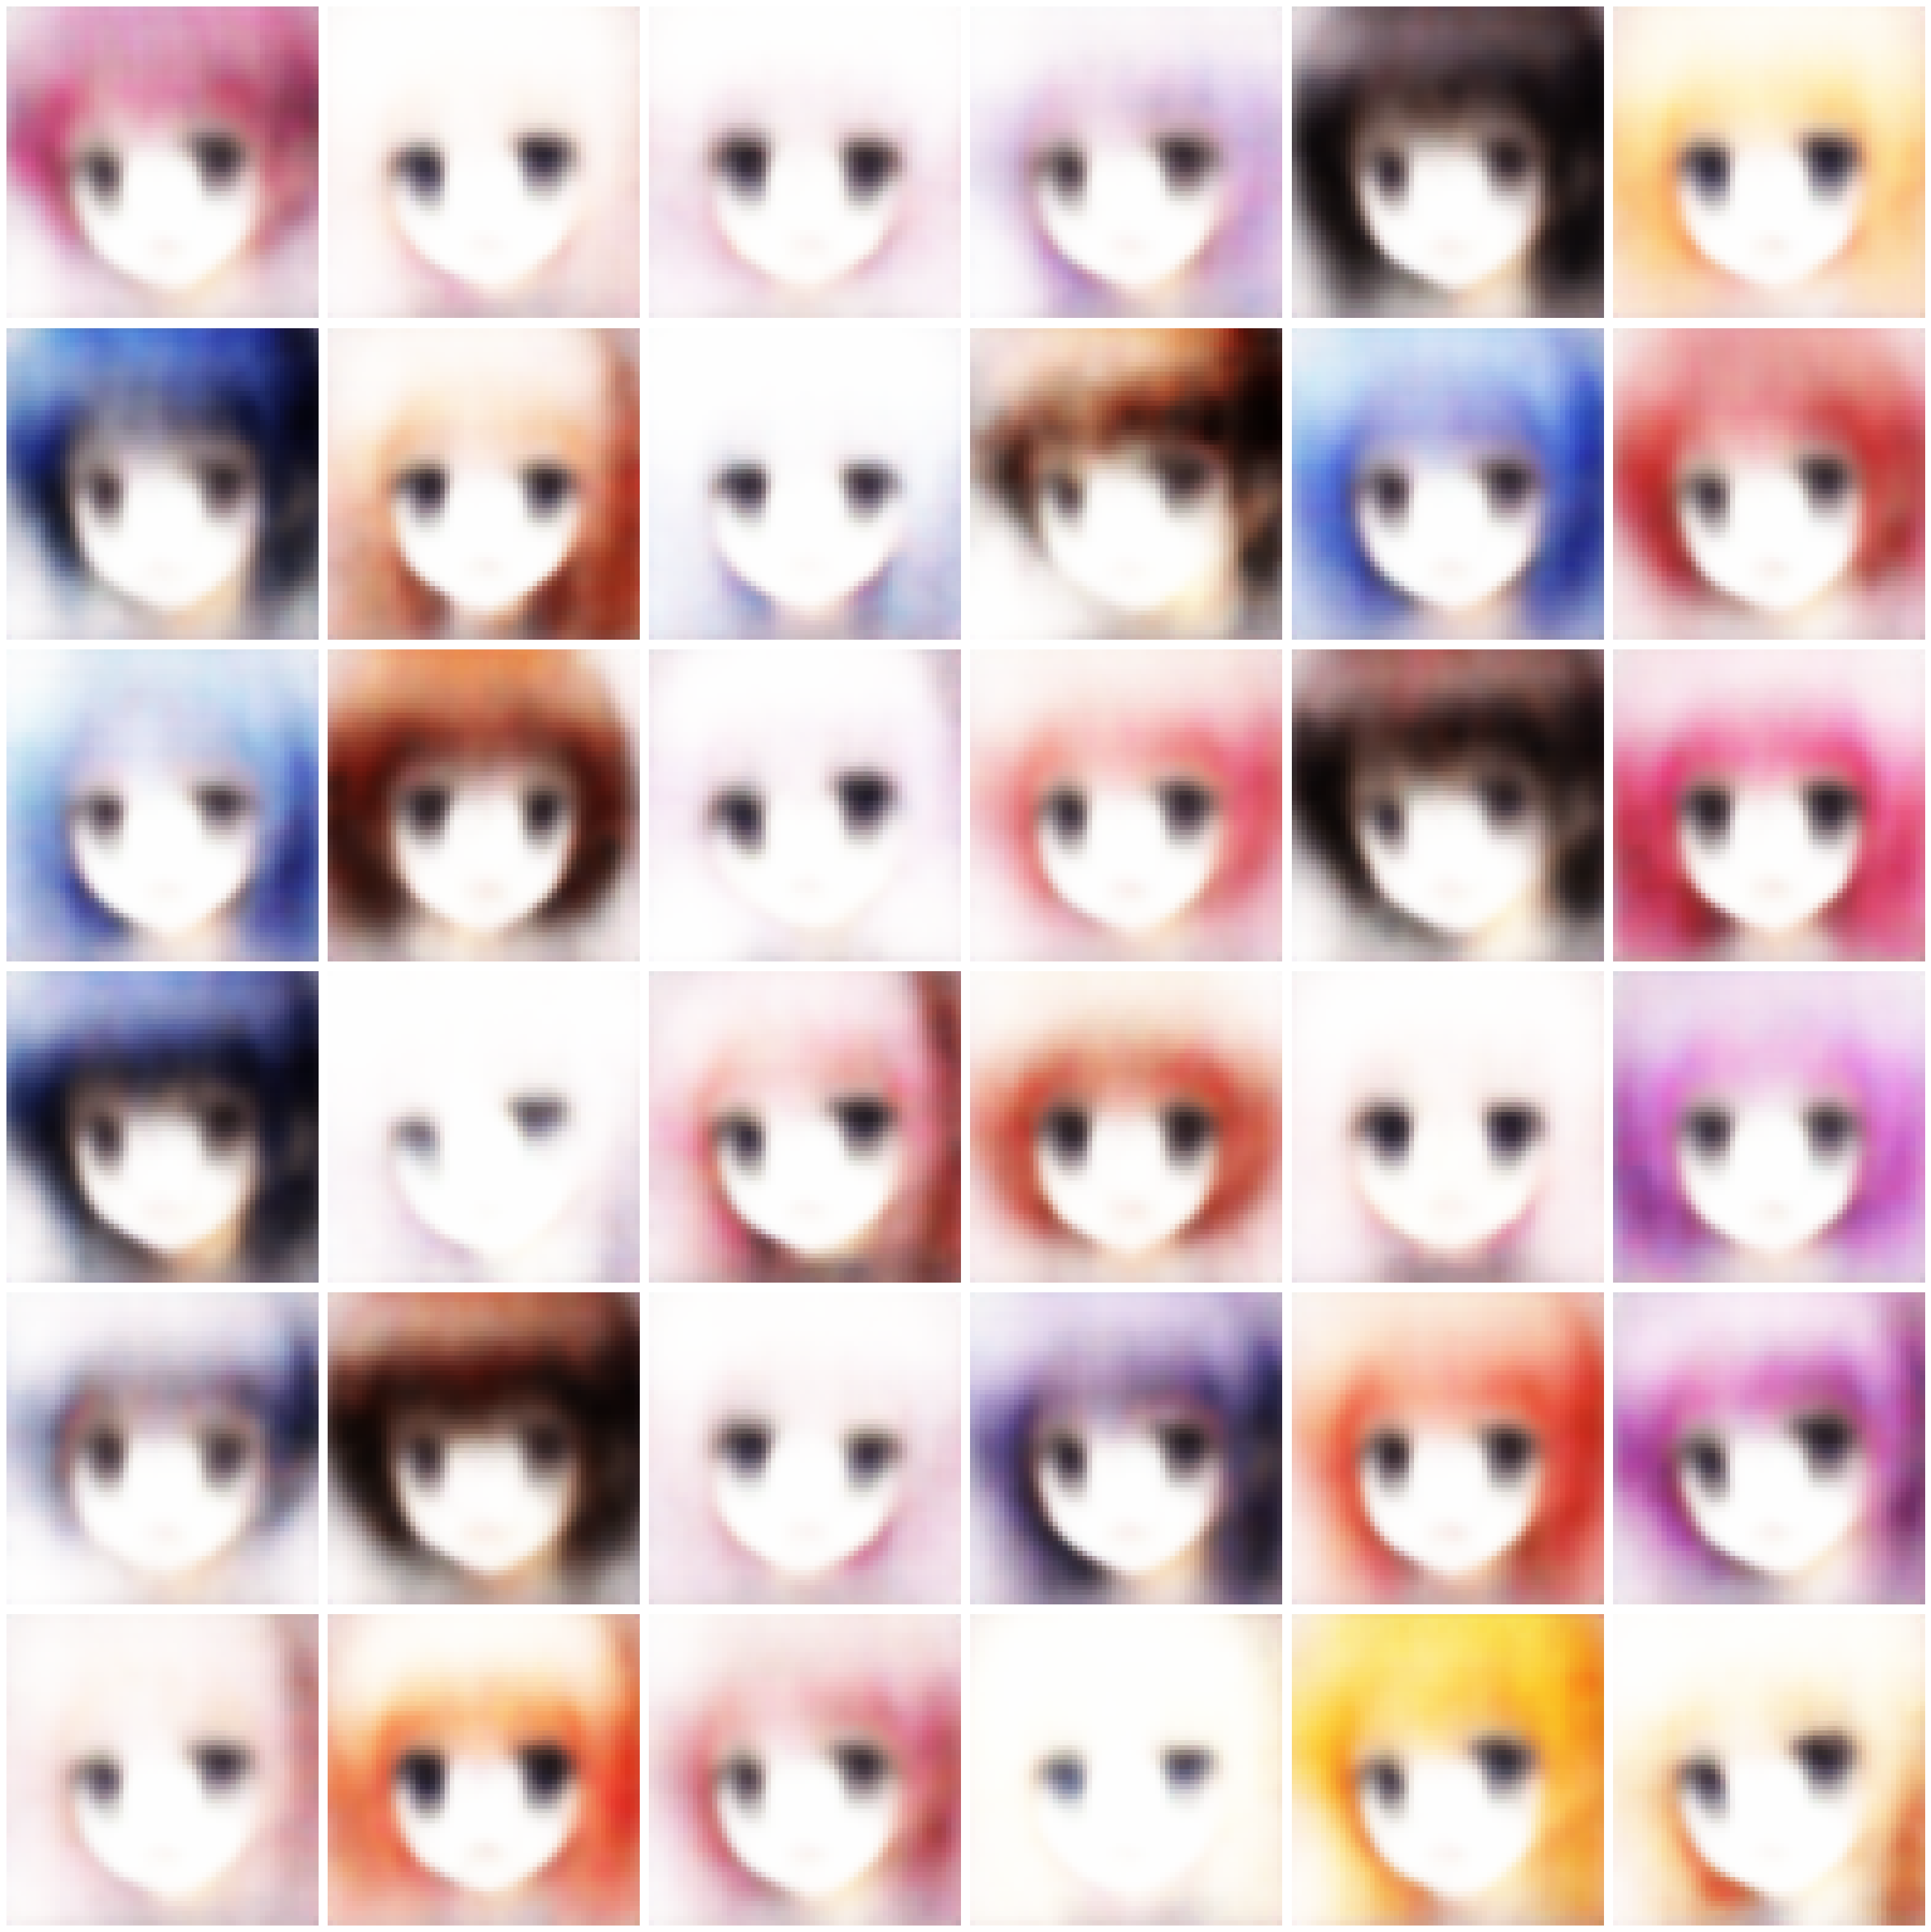

(a,b): 1.5 0.9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


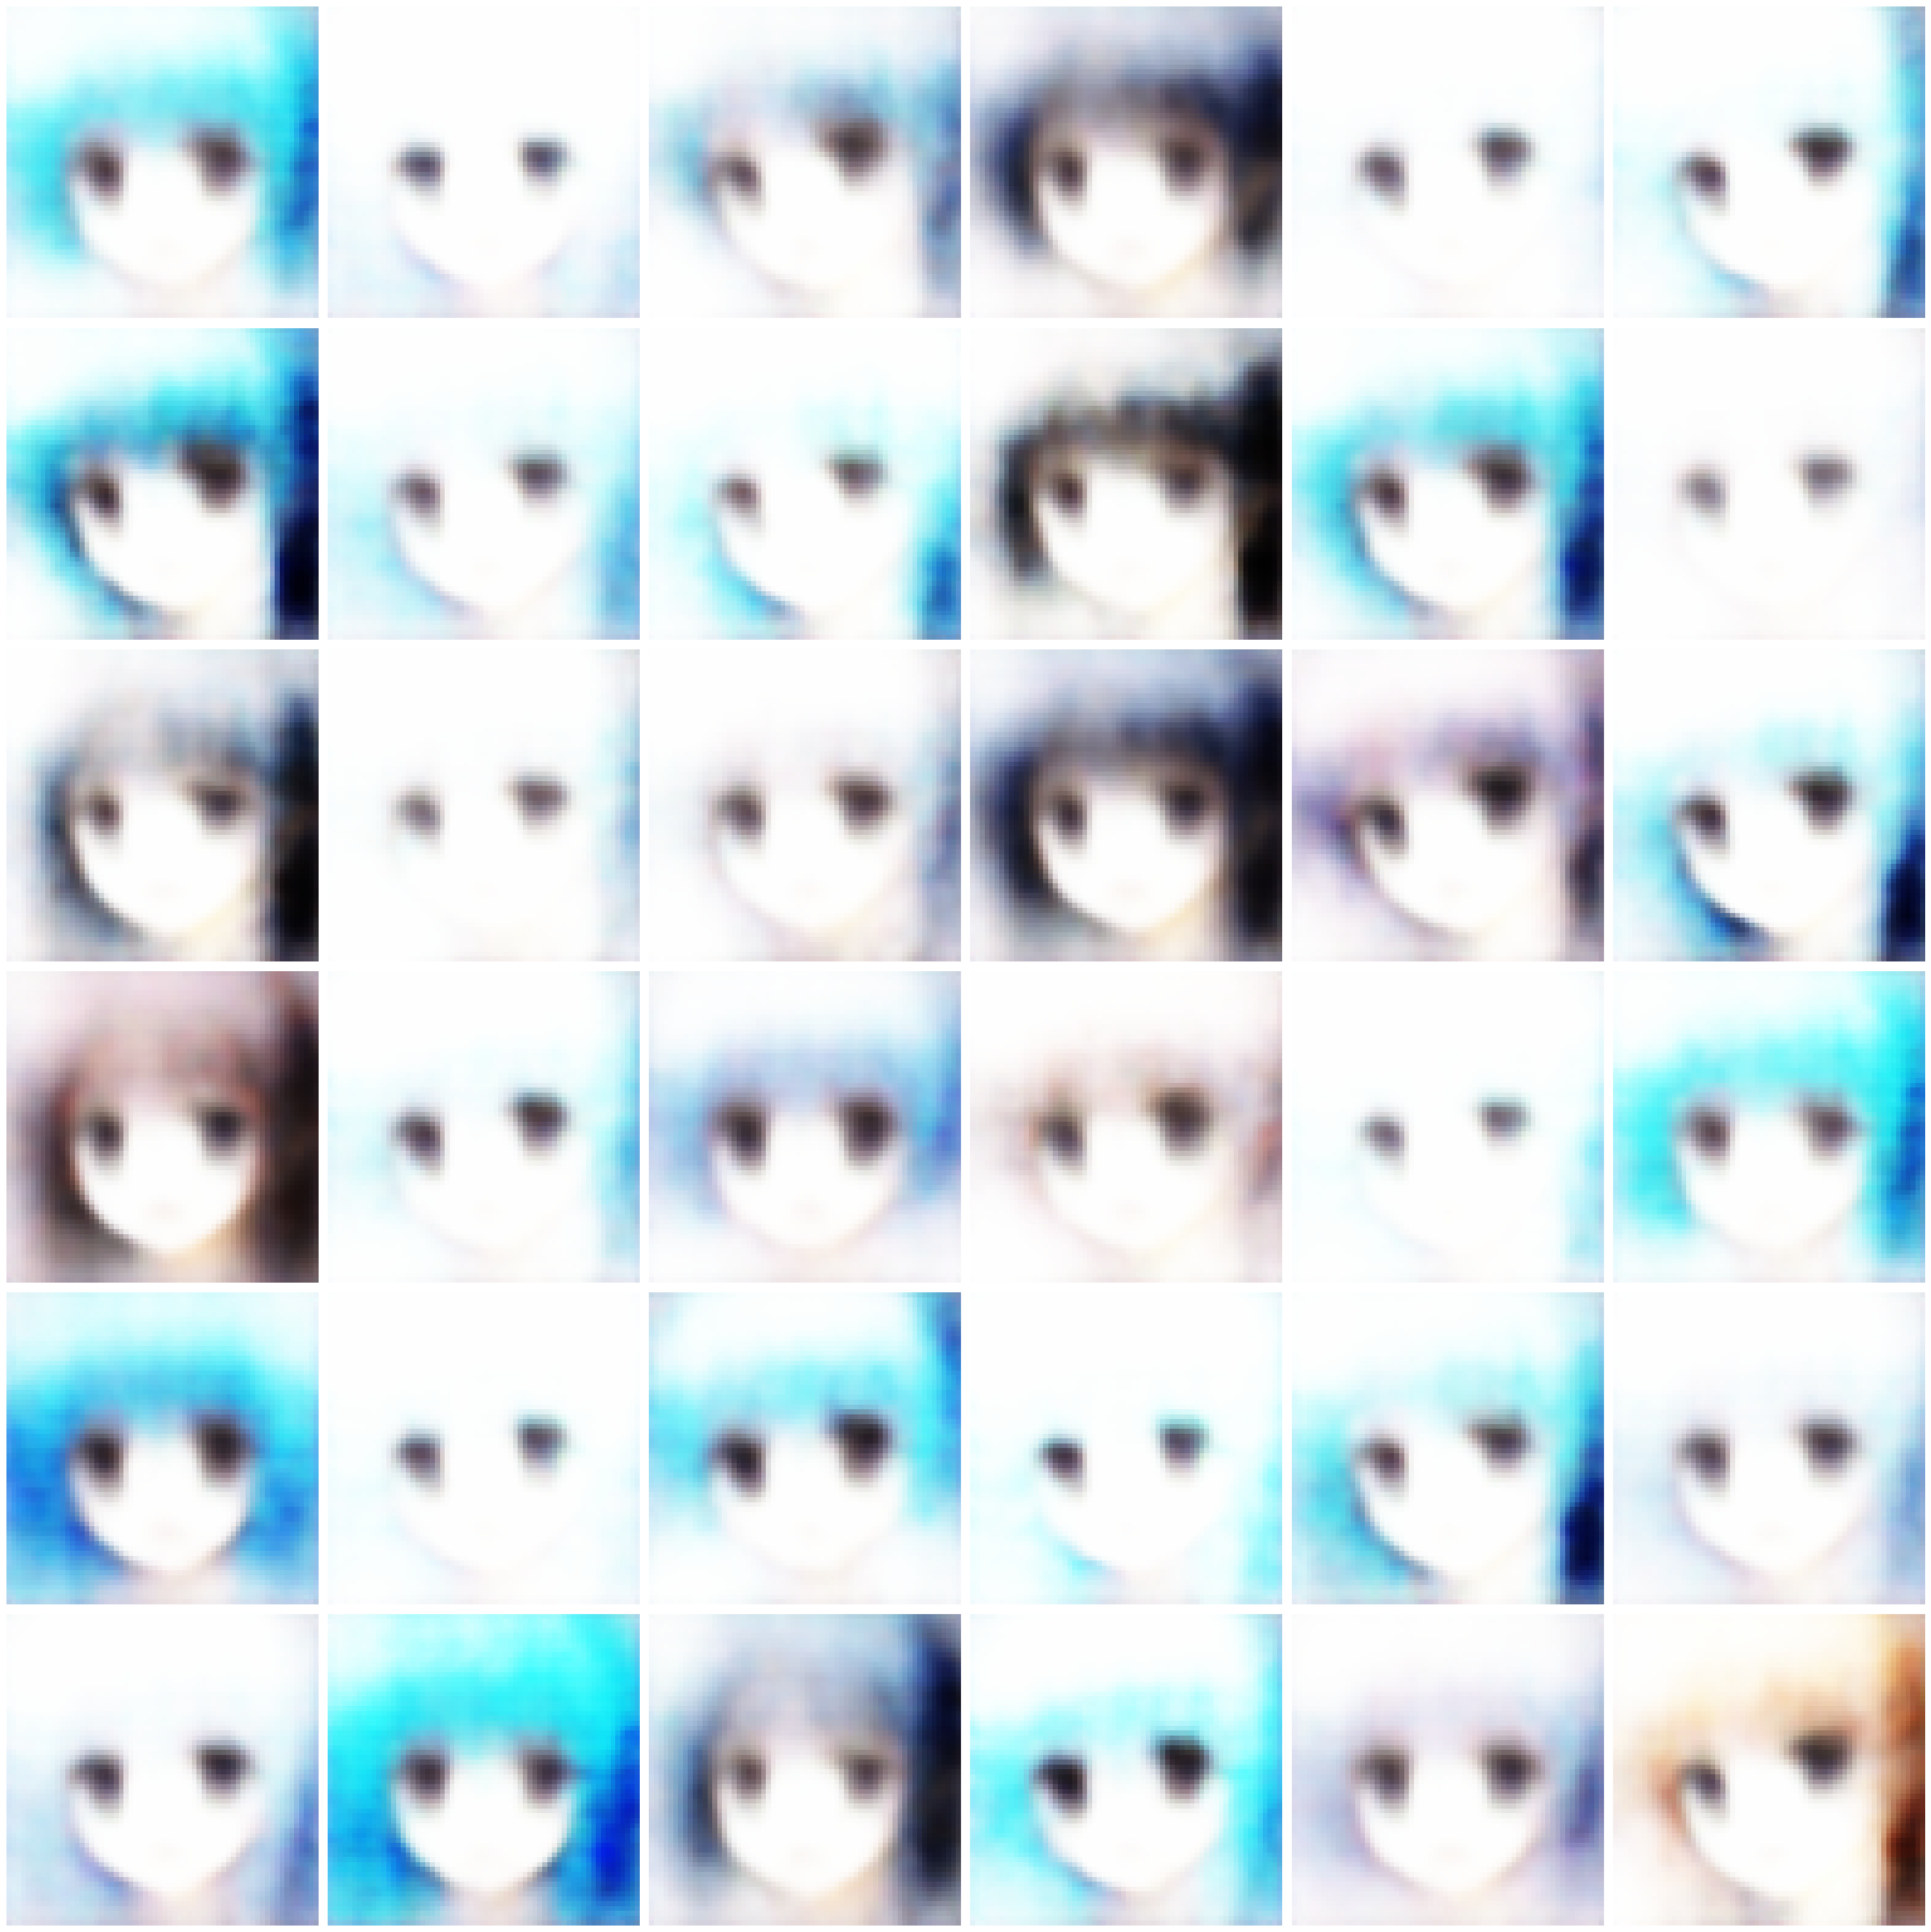

In [97]:
for i in range(4):
    plot_function(6,i-1.5,0.9)

In [89]:
vae.save("/kaggle/working/whole_vae.keras")